In [1]:
# ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 実験の設定
$\sin(2\pi x)$にノイズがのったようなデータを例に、モデルの容量とバイアス、バリアンス、ノイズの関係について見てみます。

In [2]:
sigma = 0.2

def target(x):
    t = np.sin(x * 2 * np.pi) + sigma * np.random.normal(size=x.shape)
    return t

def target_ideal(x):
    t = np.sin(x * 2 * np.pi)
    return t


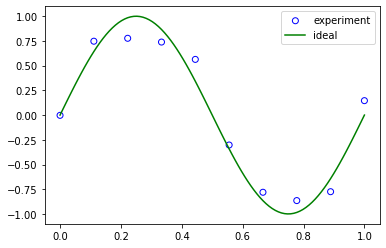

In [3]:
x = np.linspace(0, 1, 10)
x_plot = np.linspace(0, 1, 100)
x_eval = np.linspace(0, 1, 100)

plt.scatter(x, target(x), facecolor='None', edgecolors='b', label='experiment')
plt.plot(x_plot, target_ideal(x_plot), color='green', label='ideal')
plt.legend()
plt.show()

## フィット関数と目的関数
モデルとしては、多項式関数を使用します。
$$
  y(x | w) = \sum_{n=0}^M w_n x^n
$$
ロス関数としてはデータのノイズも考慮した二乗誤差を使用します
$$
  \mathcal{L} = \sum_{i \in \rm{data}} \frac{(y(x_i|w) - t_i)^2}{2\sigma^2}
$$
が、モデルの自由度を調節するために、$w$に関する制約を加えます。
$$
  \mathcal{L} = \sum_{i \in \rm{data}} \frac{(y(x_i|w) - t_i)^2}{2\sigma^2} + \frac{1}{2} \lambda |w|^2
$$

In [4]:
def _solve_exact(M, x, t):
    x_repeat = np.repeat(np.expand_dims(x, axis=-1), M + 1, axis=-1)
    degree = np.arange(M + 1)
    x_power = np.power(x_repeat, degree)
    w, _, _, _ = np.linalg.lstsq(x_power, t, rcond=None)
    return w

# machine learning model (polynominal function)
# y = sum_n w_n * (x ^ n)
def model(x, w):
    x_repeat = np.repeat(np.expand_dims(x, axis=-1), len(w), axis=-1)
    degree = np.arange(len(w))
    x_power = np.power(x_repeat, degree)
    return (x_power * w).sum(axis=-1)

def loss_func(w, x, t, l=0.):
    y = model(x, w)
    return 0.5 * (((y - t) / sigma) ** 2).mean() + 0.5 * l * (w ** 2).mean()

def fit(M, x, t, l=0.):
    # First, minimize the loss without L2 term
    w_init = _solve_exact(M, x, t)

    # Then, minimize the loss with L2 term
    from scipy.optimize import minimize
    res = minimize(loss_func, w_init, args=(x, t, l), method='BFGS')
    return res.x


## 多項式フィットの例

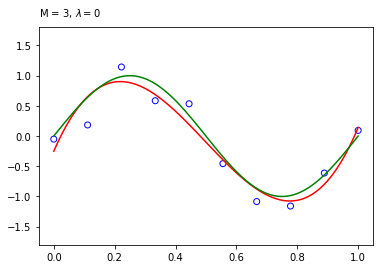

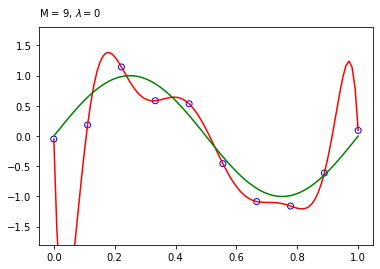

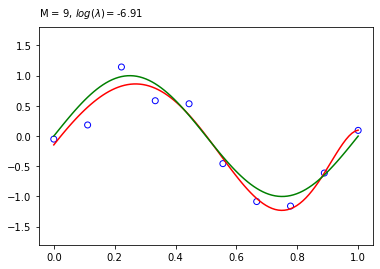

In [5]:
t = target(x)

fig, ax = plt.subplots()
w = fit(3, x, t, 0.)  # M = 3, lambda = 0.
plt.plot(x_plot, model(x_plot, w), color='red')
plt.scatter(x, t, facecolor='None', edgecolors='b')
plt.plot(x_plot, target_ideal(x_plot), color='green')
plt.ylim(-1.8, 1.8)
plt.text(0, 1.05, r'M = 3, $\lambda = 0$', transform=ax.transAxes)
plt.show()

fig, ax = plt.subplots()
w = fit(9, x, t, 0.)  # M = 3, lambda = 0.
plt.plot(x_plot, model(x_plot, w), color='red')
plt.scatter(x, t, facecolor='None', edgecolors='b')
plt.plot(x_plot, target_ideal(x_plot), color='green')
plt.ylim(-1.8, 1.8)
plt.text(0, 1.05, r'M = 9, $\lambda = 0$', transform=ax.transAxes)
plt.show()

fig, ax = plt.subplots()
w = fit(9, x, t, 1e-3)  # M = 9, lambda = 1e-3
plt.plot(x_plot, model(x_plot, w), color='red')
plt.scatter(x, t, facecolor='None', edgecolors='b')
plt.plot(x_plot, target_ideal(x_plot), color='green')
plt.ylim(-1.8, 1.8)
plt.text(0, 1.05, r'M = 9, $log(\lambda) = $' + f'{np.log(1e-3): 0.2f}', transform=ax.transAxes)
plt.show()

次数(M=3)のときは真の分布(sin(x))に近い予測が得られています。

M=9のときは、データにはよく一致していますが、データのノイズに強く適合してしまっており、真の分布(sin(x))からは外れた予測となっています。

M=9の場合でも、モデルに適度な制約を入れると、真の分布(sin(x))に近い予測が得られます。

## モデル容量を変化させたときのフィット結果の比較
データを100セット分ランダムに生成して、分布のフィットを行います。

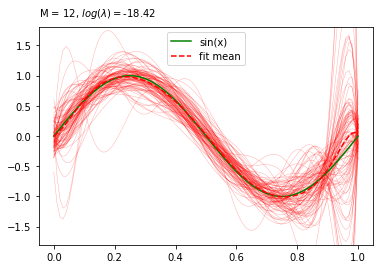

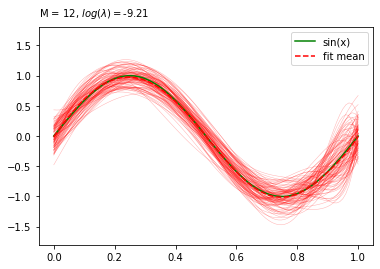

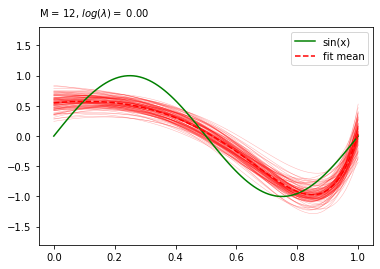

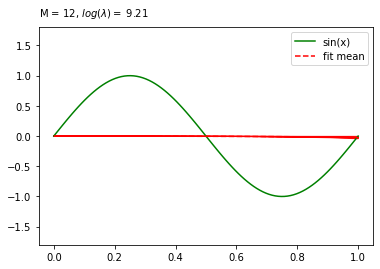

In [6]:
N = 100
M = 12
for l in [1e-8, 1e-4, 1e-0, 1e+4]:
    fig, ax = plt.subplots()

    y_all = []
    for idx in range(N):
        t = target(x)
        w = fit(M, x, t, l)
        y = model(x_plot, w)
        y_all += [y]
        plt.plot(x_plot, y, color='red', alpha=0.3, linewidth=0.5, label=None)

    y_mean = np.array(y_all).mean(axis=0)
    plt.plot(x_plot, target_ideal(x_plot), color='green', label='sin(x)')
    plt.plot(x_plot, y_mean, color='red', linestyle='dashed', label='fit mean')
    plt.ylim(-1.8, 1.8)
    plt.text(0, 1.05, f'M = {M}, ' + r'$log(\lambda) = $' + f'{np.log(l): 0.2f}', transform=ax.transAxes)
    plt.legend()
    plt.show()

M=12としてモデルの容量を大きくした場合、制約($\log(\lambda)$)が小さい場合は個々の実験の予測結果が大きくばらついています。一方で、その平均は真の分布に近いものとなっています。

制約の大きさを強くしていくと、予測のばらつき(variance)は小さくなりますが、真の分布からの系統的なずれ(bias)は大きくなっていきます。

## 多項式の最大次数(M)に対する依存性
制約項なしで、次数Mに対する経験損失(in sample error)、予測損失(汎化誤差)(out-of-sample error)を見てみます。

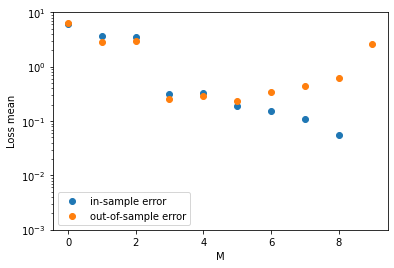

In [7]:
loss_in = []
loss_out = []
N = 100
M_cand = np.arange(0, 10)
for M in M_cand:
    loss_in_tmp = 0.
    loss_out_tmp = 0.
    for idx in range(N):
        t = target(x)
        w = fit(M, x, t)

        loss_in_tmp += loss_func(w, x, t)
        loss_out_tmp += loss_func(w, x_plot, target_ideal(x_plot))
    loss_in += [loss_in_tmp / N]
    loss_out += [loss_out_tmp / N]

plt.scatter(M_cand, loss_in, label='in-sample error')
plt.scatter(M_cand, loss_out, label='out-of-sample error')
plt.ylim(1e-3, 1e+1)
plt.yscale('log')
plt.xlabel('M')
plt.ylabel('Loss mean')
plt.legend()
plt.show()

次数(M)が大きくなると、in-sample errorとout-of-sample errorの差が大きくなっていきます。これは、過学習によって汎化性能が悪化していることが示唆されます。

また、汎化性能を考えるとM=3がベストなこともわかります。

エラーをbias, variance, noiseに分解してみてみます。
$$
  \begin{align*}
    \rm{Total} &= \mathbb{E}_D[\{y(x; D) - t\}^2] \\
    \rm{Bias} &= \{\mathbb{E}_D[y(x; D)] - \mathbb{E}_D[t | x]\}^2 \\
    \rm{Variance} &= \mathbb{E}_D[\{y(x; D) - \mathbb{E}_D[y(x; D)]\}^2] \\
    \rm{Noise} &= \{t - \mathbb{E}_D[t | x]\}^2 \\
  \end{align*}
$$

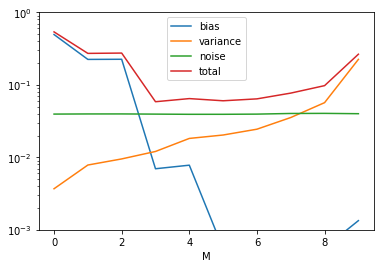

In [8]:
bias = []
variance = []
noise = []
total = []

N = 100
M_cand = np.arange(0, 10)
for M in M_cand:
    # Sampling for evaluation (independent of training samples)
    y_eval = target(np.repeat(x_eval[np.newaxis, :], N, axis=0))

    y_pred = []
    for _ in range(N):
        # Training model using a few samples 
        t = target(x)
        w = fit(M, x, t)
        y_pred += [model(x_eval, w)]
    
    y_pred = np.array(y_pred)

    bias += [((y_pred.mean(axis=0) - y_eval.mean(axis=0)) ** 2).mean()]
    variance += [y_pred.var(axis=0).mean()]
    noise += [((y_eval - y_eval.mean(axis=0)) ** 2).mean(axis=0).mean()]
    total += [((y_pred - y_eval) ** 2).mean(axis=0).mean()]

plt.plot(M_cand, bias, label='bias')
plt.plot(M_cand, variance, label='variance')
plt.plot(M_cand, noise, label='noise')
plt.plot(M_cand, total, label='total')
plt.ylim(1e-3, 1e+0)
plt.yscale('log')
plt.xlabel('M')
plt.legend()
plt.show()

次数(M)が小さいとバイアスが大きく、次数(M)が大きいとバリアンスが大きくなります。ノイズはモデルには依存しない項で、次数(M)に依存しません。

## モデル容量($\lambda$)に対する依存性

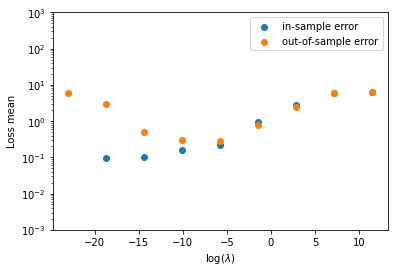

In [9]:
loss_in = []
loss_out = []
N = 100
M = 12
lambdas = np.logspace(-10, 5, 9)
for l in lambdas:
    loss_in_tmp = 0.
    loss_out_tmp = 0.
    for idx in range(N):
        t = target(x)
        w = fit(M, x, t, l)

        loss_in_tmp += loss_func(w, x, t)
        loss_out_tmp += loss_func(w, x_plot, target_ideal(x_plot))
    loss_in += [loss_in_tmp / N]
    loss_out += [loss_out_tmp / N]

plt.scatter(np.log(lambdas), loss_in, label='in-sample error')
plt.scatter(np.log(lambdas), loss_out, label='out-of-sample error')
plt.ylim(1e-3, 1e+3)
plt.yscale('log')
plt.xlabel(r'$\log(\lambda)$')
plt.ylabel('Loss mean')
plt.legend()
plt.show()


### Bias, Variance, and Noise

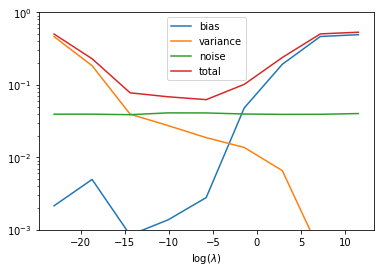

In [10]:
bias = []
variance = []
noise = []
total = []

N = 100
M = 12
lambdas = np.logspace(-10, 5, 9)
for l in lambdas:
    # Sampling for evaluation (independent of training samples)
    y_eval = target(np.repeat(x_eval[np.newaxis, :], N, axis=0))

    y_pred = []
    cut = np.ones(N, dtype='bool')
    for idx in range(N):
        # Training model using a few samples 
        t = target(x)
        w = fit(M, x, t, l)

        # loss = loss_func(w, x, t)
        # if loss > 20.:
        #     cut[idx] = False

        y_pred += [model(x_eval, w)]
    
    y_pred = np.array(y_pred)

    y_pred = y_pred[cut]
    y_eval = y_eval[cut]

    bias += [((y_pred.mean(axis=0) - y_eval.mean(axis=0)) ** 2).mean()]
    variance += [y_pred.var(axis=0).mean()]
    noise += [((y_eval - y_eval.mean(axis=0)) ** 2).mean(axis=0).mean()]
    total += [((y_pred - y_eval) ** 2).mean(axis=0).mean()]

plt.plot(np.log(lambdas), bias, label='bias')
plt.plot(np.log(lambdas), variance, label='variance')
plt.plot(np.log(lambdas), noise, label='noise')
plt.plot(np.log(lambdas), total, label='total')
plt.ylim(1e-3, 1e+0)
plt.yscale('log')
plt.xlabel(r'$\log(\lambda)$')
plt.legend()


$\lambda$を大きくしてモデル容量が小さくなるとバイアスが大きく、$\lambda$を小さくしてモデル容量が大きくなるとバリアンスが大きくなります。ノイズはモデルには依存しない項で、次数(M)に依存しません。